# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Rating-study" data-toc-modified-id="Rating-study-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Rating study</a></div><div class="lev2 toc-item"><a href="#Grouping-by-metropolitan-(cities)" data-toc-modified-id="Grouping-by-metropolitan-(cities)-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Grouping by <code>metropolitan</code> (cities)</a></div><div class="lev3 toc-item"><a href="#Remarks" data-toc-modified-id="Remarks-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Remarks</a></div><div class="lev2 toc-item"><a href="#Grouping-by-room_type" data-toc-modified-id="Grouping-by-room_type-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Grouping by <code>room_type</code></a></div><div class="lev3 toc-item"><a href="#Remarks" data-toc-modified-id="Remarks-121"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Remarks</a></div><div class="lev2 toc-item"><a href="#Finding-the-most-important-amenity-per-room_type" data-toc-modified-id="Finding-the-most-important-amenity-per-room_type-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Finding the most important amenity per <code>room_type</code></a></div><div class="lev3 toc-item"><a href="#Remarks" data-toc-modified-id="Remarks-131"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Remarks</a></div><div class="lev2 toc-item"><a href="#Finding-the-most-important-amenity-per-metropolitan" data-toc-modified-id="Finding-the-most-important-amenity-per-metropolitan-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Finding the most important amenity per <code>metropolitan</code></a></div><div class="lev1 toc-item"><a href="#Modeling-the-rating" data-toc-modified-id="Modeling-the-rating-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling the rating</a></div>

In [69]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

import statsmodels.api as sm
import statsmodels.formula.api as smf

import cufflinks as cf

from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

import matplotlib.pyplot as plt
import seaborn as sns

import tools
import metrics

# Set options
init_notebook_mode(connected=True)
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None  # default='warn'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
% ls data/
datapath='data/'

archives/         demographics.csv  listings.csv      venues.csv
calendar.csv      econ_state.csv    real_estate.csv


In [5]:
%%time
listings_df, all_amenities = tools.load_listings()
# Reformat t, f columns
listings_df.head()
listings_df.info()

/Users/remus/Envs/louisvenv/lib/python3.5/site-packages/IPython/core/magic.py:187: DtypeWarning:

Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56417 entries, 0 to 56416
Columns: 125 entries, accommodates to cancellation_policy_super_strict_60
dtypes: bool(2), float64(13), int64(95), object(9), uint8(6)
memory usage: 50.8+ MB
CPU times: user 5.97 s, sys: 374 ms, total: 6.34 s
Wall time: 6.45 s


In [6]:
reg_data = listings_df.select_dtypes(include=['int64','float64'])
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56417 entries, 0 to 56416
Columns: 108 entries, accommodates to wireless_internet
dtypes: float64(13), int64(95)
memory usage: 46.5 MB


In [7]:
columns_to_drop = ['latitude', 'longitude', 'host_id', 'id']

# Dropping specific columns
reg_data.drop(columns_to_drop, inplace=True, axis=1)
# Dropping NaNs
reg_data.dropna(inplace=True)

reg_data.shape

y = reg_data['price']
x = reg_data.drop(['price'], axis=1)

/Users/remus/Envs/louisvenv/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/remus/Envs/louisvenv/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(42854, 104)

In [57]:
reg = RidgeCV()
reg.fit(x, y)
coeffs = pd.DataFrame(reg.coef_, index=x.columns)
coeffs.sort_values(by=0).iplot(kind='bar')

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

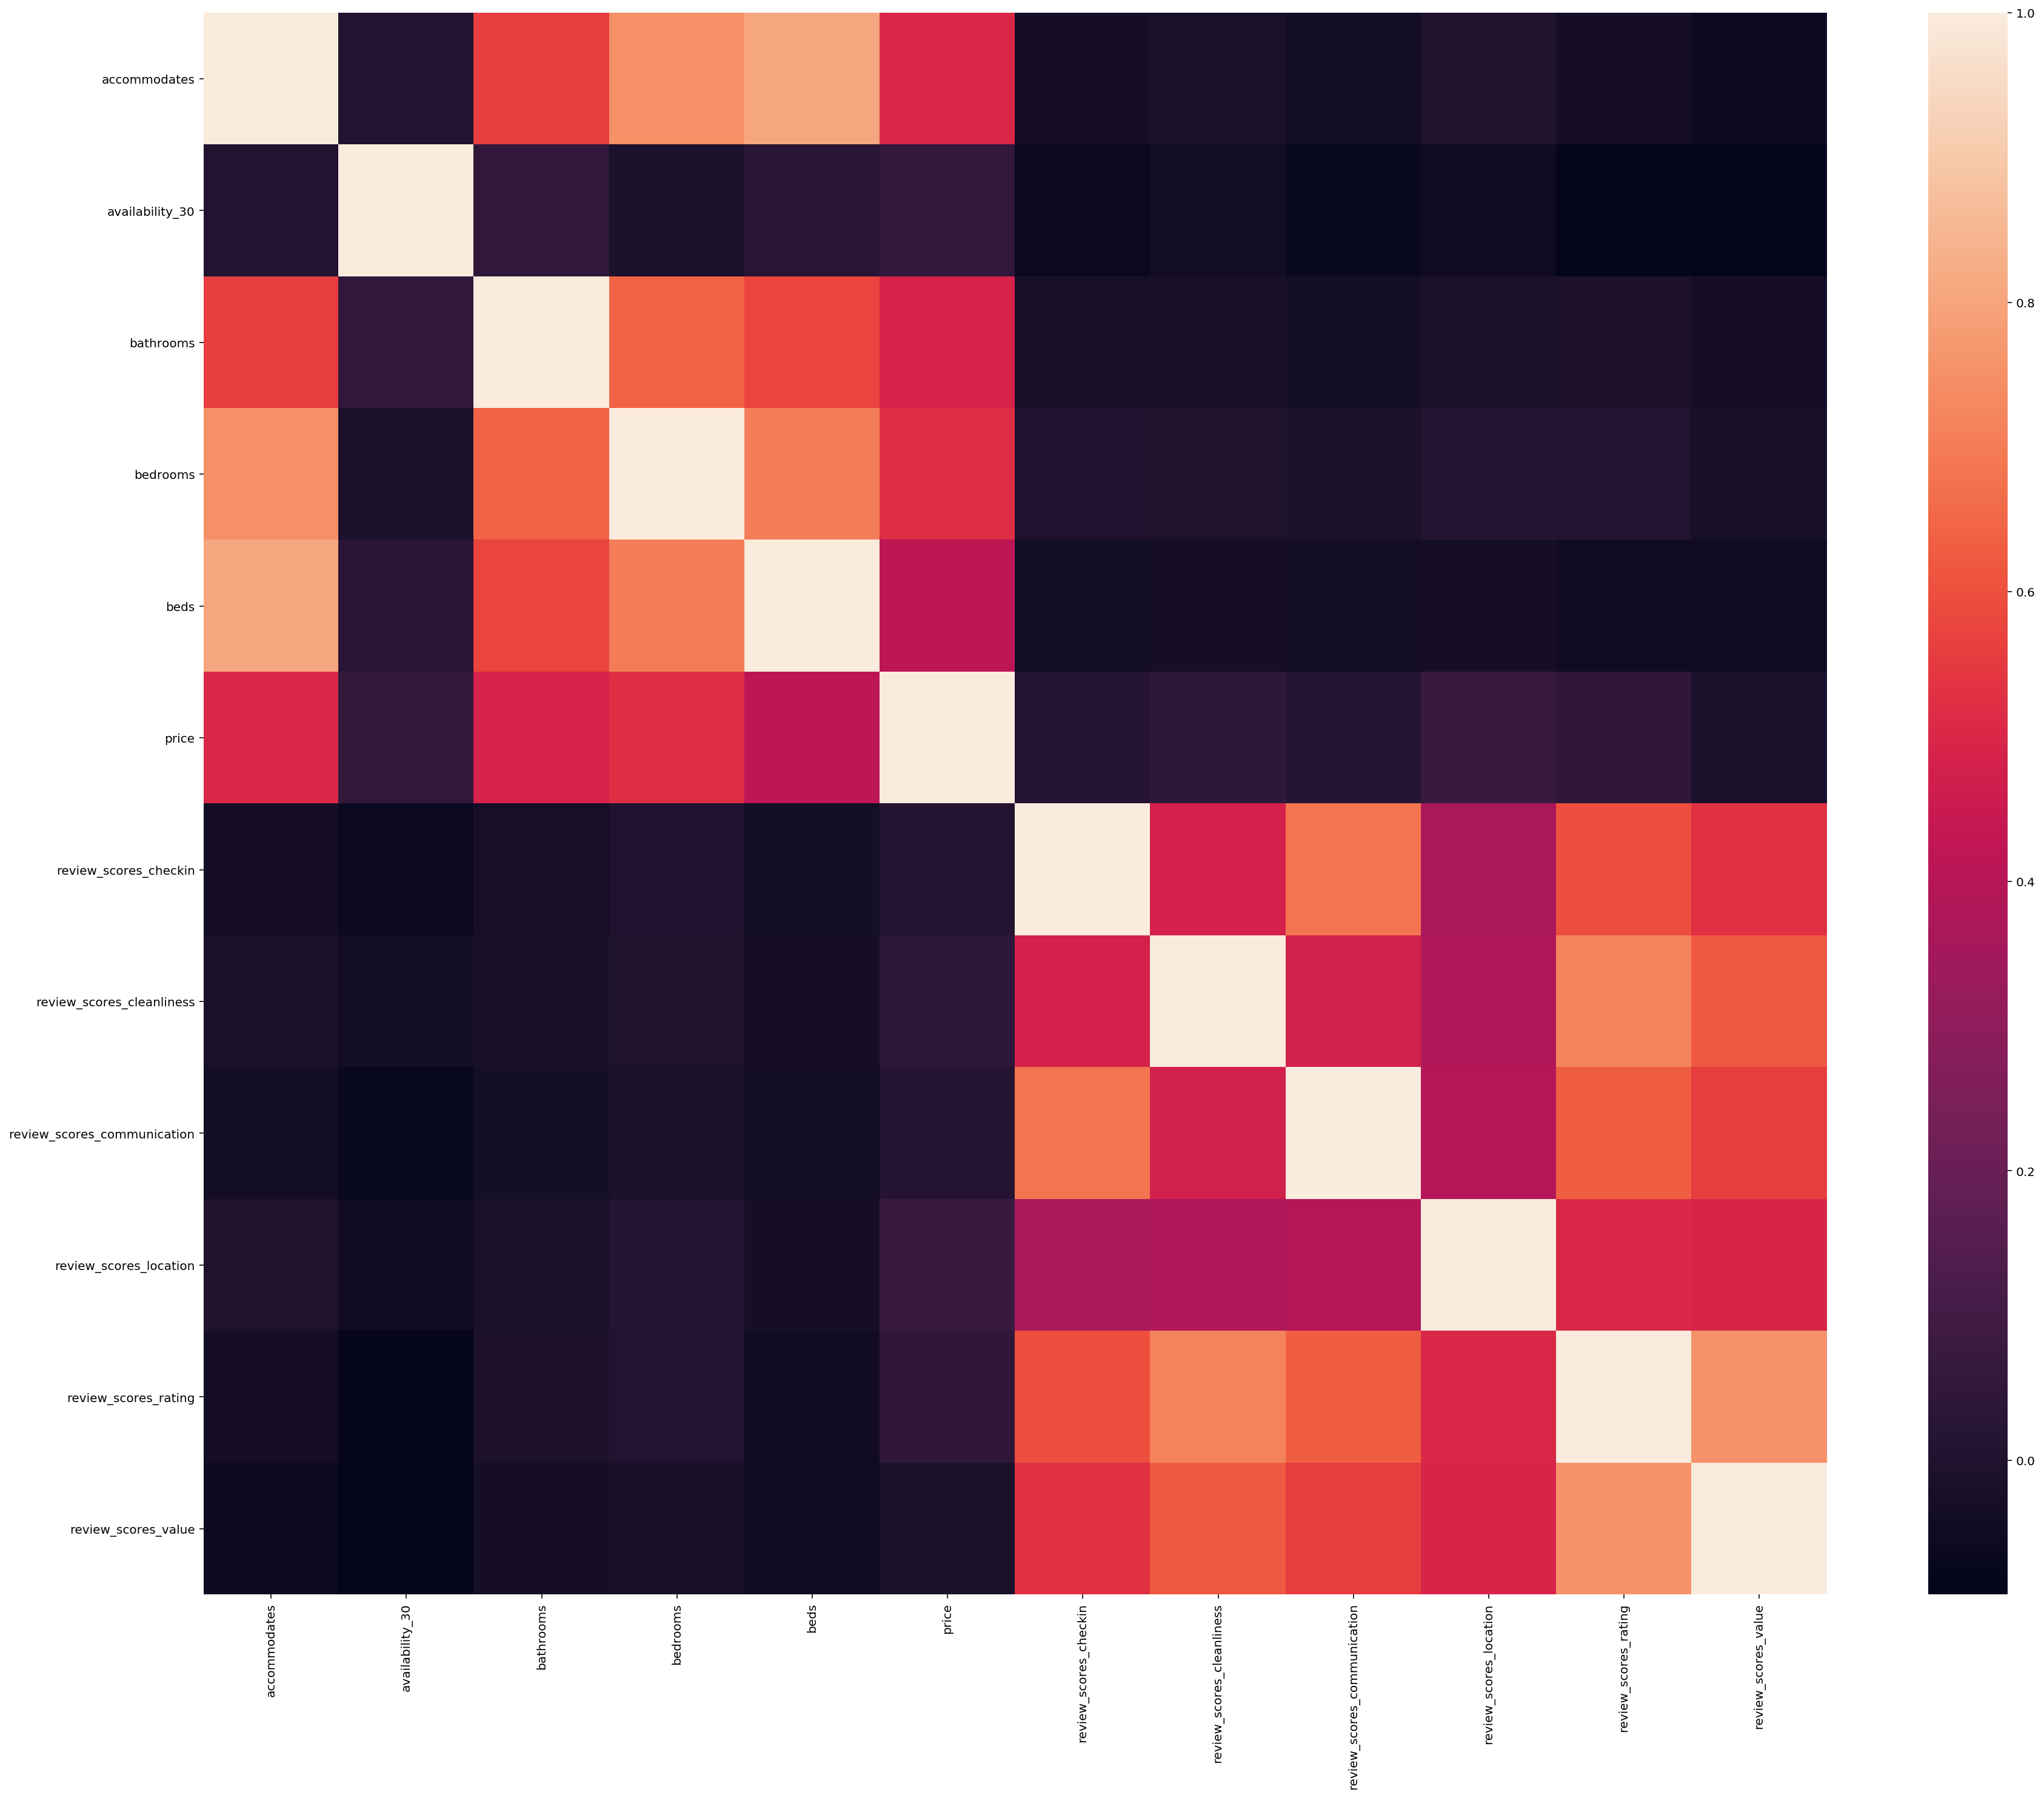

In [130]:
# See what drives the price
tmp_corr = reg_data.drop(list(all_amenities), axis=1).corr()
plt.figure(figsize=(30, 24));
sns.heatmap(tmp_corr, 
            xticklabels=tmp_corr.columns.values,
            yticklabels=tmp_corr.columns.values);

In [148]:
correl_data = listings_df.copy()

columns_to_drop = ['latitude', 'longitude', 'host_id', 'id']
# Dropping specific columns
correl_data.drop(columns_to_drop, inplace=True, axis=1)
# Dropping NaNs
correl_data.dropna(inplace=True)

In [162]:
correl_data =  pd.get_dummies(correl_data, columns=['cancellation_policy', 'instant_bookable'])

# Rating study

## Grouping by `metropolitan` (cities)

In [163]:
target = 'review_scores_rating'
sep = 'metropolitan'
for name, group in correl_data.groupby(sep):
    print('{}: {}\n'.format(sep.title(), name.title()))
    tmp_corr = group.drop(list(all_amenities), axis=1).corr()
    plt.figure(figsize=(30, 24));
#     sns.heatmap(tmp_corr, 
#                 xticklabels=tmp_corr.columns.values,
#                 yticklabels=tmp_corr.columns.values);
#     plt.show();
    tmp_corr.loc[target].iplot(kind='bar', title="Grouped by {}<br>{}<br>{} correlation".format(sep, name, target));
    print('\n\n')

Metropolitan: La






Metropolitan: Oakland






Metropolitan: Portland






Metropolitan: San_Diego






Metropolitan: San_Francisco






Metropolitan: Santa_Cruz






Metropolitan: Seattle



### Remarks
`review_score_location` is always the least important review_score.  
For most cities, the two most correlated ratings with the `review_score_ratings` is:
- `review_score_cleanliness`
- `review_score_value`

In some cities (Santa Cruz, San Diego, Portland), the features:
- `accommodates`, 
- `bathrooms`, 
- `bedrooms`
- `beds`

are negatively correlated with the review_score_rating.  
Not the case for Oakland !

Negative correlation with `instant_booking` (property not ready, bad checking in experience?).  
Negative correlation with `availability_30` (?).  
A strict `cancellation_policy` is generally negatively correlated with the `review_scores_ratings`, except for San Francisco (tech people don't care?). A flexible `cancellation_policy` in San Francisco, Santa Cruz, Oakland and LA is also negatively correlated with the `review_scores_rating`.  
Being `instantly_bookable` is also generally negatively correlated with `review_scores_ratings`.  

## Grouping by `room_type`

In [164]:
target = 'review_scores_rating'
sep = 'room_type'
for name, group in correl_data.groupby(sep):
    print('{}: {}\n'.format(sep.title(), name.title()))
    tmp_corr = group.drop(list(all_amenities), axis=1).corr()
    plt.figure(figsize=(30, 24));
#     sns.heatmap(tmp_corr, 
#                 xticklabels=tmp_corr.columns.values,
#                 yticklabels=tmp_corr.columns.values);
#     plt.show();
    tmp_corr.loc[target].iplot(kind='bar', title="Grouped by {}<br>{}<br>{} correlation".format(sep, name, target));
    print('\n\n')

Room_Type: Entire Home/Apt






Room_Type: Private Room






Room_Type: Shared Room



### Remarks

It is only for `shared_rooms` that the `review_score_checkin` becomes more important than the `review_score_cleanliness`.  
`review_score_value` is always the most important review.  
Having a strict `cancellation_policy` is negatively correlated with `review_scores_rating`.

## Finding the most important amenity per `room_type`

In [189]:
target = 'review_scores_rating'
sep = 'room_type'
df = correl_data[[target, sep] + list(all_amenities)]
for name, group in df.groupby(sep):

    tmp_corr = group.corr()
    plt.figure(figsize=(30, 24));
#     sns.heatmap(tmp_corr, 
#                 xticklabels=tmp_corr.columns.values,
#                 yticklabels=tmp_corr.columns.values);
#     plt.show();
    sorted_corr = tmp_corr.loc[target].sort_values(0, ascending=False)
    sorted_corr.iplot(kind='bar', title="Grouped by {}<br>{}<br>{} correlation".format(sep, name, target));
    print('{}: {}\n'.format(sep.title(), name.title()))
    print("Top 5 most POSITIVELY correlated amenities:\n{}\n".format(sorted_corr.dropna().head()))
    print("Top 5 most NEGATIVELY correlated amenities:\n{}\n".format(sorted_corr.dropna().tail()))
    print('\n\n')

Room_Type: Entire Home/Apt

Top 5 most POSITIVELY correlated amenities:
review_scores_rating    1.000000
first aid kit           0.108565
shampoo                 0.105996
fire extinguisher       0.098475
hair dryer              0.092835
Name: review_scores_rating, dtype: float64

Top 5 most NEGATIVELY correlated amenities:
elevator in building    -0.031658
family/kid friendly     -0.040658
wheelchair accessible   -0.045492
suitable for events     -0.045539
pets allowed            -0.062659
Name: review_scores_rating, dtype: float64






Room_Type: Private Room

Top 5 most POSITIVELY correlated amenities:
review_scores_rating          1.000000
hangers                       0.128595
pets live on this property    0.122979
hair dryer                    0.121526
iron                          0.109320
Name: review_scores_rating, dtype: float64

Top 5 most NEGATIVELY correlated amenities:
family/kid friendly    -0.014796
doorman                -0.015923
elevator in building   -0.016155
smoking allowed        -0.026144
pets allowed           -0.040169
Name: review_scores_rating, dtype: float64






Room_Type: Shared Room

Top 5 most POSITIVELY correlated amenities:
review_scores_rating        1.000000
hair dryer                  0.099286
smoking allowed             0.091194
buzzer/wireless intercom    0.085880
pets allowed                0.077383
Name: review_scores_rating, dtype: float64

Top 5 most NEGATIVELY correlated amenities:
air conditioning   -0.068754
washer             -0.084501
dryer              -0.087024
internet           -0.092669
hot tub            -0.103370
Name: review_scores_rating, dtype: float64






### Remarks
- `Room_Type`: Entire Home/Apt
    - Top 5 most POSITIVELY correlated amenities:
        - review_scores_rating
        - first aid kit
        - shampoo
        - fire extinguisher
        - hair dryer

    - Top 5 most NEGATIVELY correlated amenities
        - elevator in building
        - family/kid friendly
        - wheelchair accessible
        - suitable for events
        - pets allowed  


- `Room_Type`: Private Room
    - Top 5 most POSITIVELY correlated amenities
        - review_scores_rating
        - hangers
        - pets live on this property
        - hair dryer
        - iron

    - Top 5 most NEGATIVELY correlated amenities
        - family/kid friendly
        - doorman
        - elevator in building
        - smoking allowed
        - pets allowed  


- `Room_Type`: Shared Room
    - Top 5 most POSITIVELY correlated amenities
        - review_scores_rating
        - hair dryer
        - smoking allowed
        - buzzer/wireless intercom
        - pets allowed

    - Top 5 most NEGATIVELY correlated amenities
        - air conditioning
        - washer
        - dryer
        - internet
        - hot tub

## Finding the most important amenity per `metropolitan`

In [190]:
target = 'review_scores_rating'
sep = 'metropolitan'
df = correl_data[[target, sep] + list(all_amenities)]
for name, group in df.groupby(sep):

    tmp_corr = group.corr()
    plt.figure(figsize=(30, 24));
#     sns.heatmap(tmp_corr, 
#                 xticklabels=tmp_corr.columns.values,
#                 yticklabels=tmp_corr.columns.values);
#     plt.show();
    sorted_corr = tmp_corr.loc[target].sort_values(0, ascending=False)
    sorted_corr.iplot(kind='bar', title="Grouped by {}<br>{}<br>{} correlation".format(sep, name, target));
    print('{}: {}\n'.format(sep.title(), name.title()))
    print("Top 5 most POSITIVELY correlated amenities:\n{}\n".format(sorted_corr.dropna().head()))
    print("Top 5 most NEGATIVELY correlated amenities:\n{}\n".format(sorted_corr.dropna().tail()))
    print('\n\n')

Metropolitan: La

Top 5 most POSITIVELY correlated amenities:
review_scores_rating          1.000000
hair dryer                    0.124108
hangers                       0.119306
pets live on this property    0.118805
heating                       0.117643
Name: review_scores_rating, dtype: float64

Top 5 most NEGATIVELY correlated amenities:
gym                     -0.019437
wheelchair accessible   -0.019834
family/kid friendly     -0.024297
elevator in building    -0.041509
pets allowed            -0.052372
Name: review_scores_rating, dtype: float64






Metropolitan: Oakland

Top 5 most POSITIVELY correlated amenities:
review_scores_rating          1.000000
shampoo                       0.081565
pets live on this property    0.076346
breakfast                     0.072282
hair dryer                    0.068891
Name: review_scores_rating, dtype: float64

Top 5 most NEGATIVELY correlated amenities:
gym                   -0.058927
dryer                 -0.062443
heating               -0.064205
pool                  -0.078575
family/kid friendly   -0.079890
Name: review_scores_rating, dtype: float64






Metropolitan: Portland

Top 5 most POSITIVELY correlated amenities:
review_scores_rating    1.000000
hair dryer              0.178441
shampoo                 0.172633
hangers                 0.172069
iron                    0.140745
Name: review_scores_rating, dtype: float64

Top 5 most NEGATIVELY correlated amenities:
doorman                -0.056008
smoking allowed        -0.059046
gym                    -0.080038
pets allowed           -0.111565
elevator in building   -0.113738
Name: review_scores_rating, dtype: float64






Metropolitan: San_Diego

Top 5 most POSITIVELY correlated amenities:
review_scores_rating    1.000000
first aid kit           0.107468
fire extinguisher       0.103243
air conditioning        0.098915
shampoo                 0.087172
Name: review_scores_rating, dtype: float64

Top 5 most NEGATIVELY correlated amenities:
suitable for events     -0.045051
kitchen                 -0.061368
wheelchair accessible   -0.087244
pets allowed            -0.104446
family/kid friendly     -0.115229
Name: review_scores_rating, dtype: float64






Metropolitan: San_Francisco

Top 5 most POSITIVELY correlated amenities:
review_scores_rating    1.000000
hair dryer              0.130224
iron                    0.128519
hangers                 0.119871
cable tv                0.119500
Name: review_scores_rating, dtype: float64

Top 5 most NEGATIVELY correlated amenities:
lock on bedroom door   -0.024922
air conditioning       -0.025098
suitable for events    -0.031080
elevator in building   -0.052878
smoking allowed        -0.057390
Name: review_scores_rating, dtype: float64






Metropolitan: Santa_Cruz

Top 5 most POSITIVELY correlated amenities:
review_scores_rating    1.000000
heating                 0.114883
other pet(s)            0.099285
breakfast               0.092436
shampoo                 0.085521
Name: review_scores_rating, dtype: float64

Top 5 most NEGATIVELY correlated amenities:
wireless internet     -0.064983
pool                  -0.071222
smoking allowed       -0.090778
family/kid friendly   -0.102388
pets allowed          -0.125054
Name: review_scores_rating, dtype: float64






Metropolitan: Seattle

Top 5 most POSITIVELY correlated amenities:
review_scores_rating        1.000000
first aid kit               0.154574
fire extinguisher           0.151381
carbon monoxide detector    0.148471
shampoo                     0.136271
Name: review_scores_rating, dtype: float64

Top 5 most NEGATIVELY correlated amenities:
pool                  -0.021359
dryer                 -0.026463
washer                -0.029439
washer / dryer        -0.048715
suitable for events   -0.052340
Name: review_scores_rating, dtype: float64






In [9]:
listings_df['price'].iplot(kind='histogram', title='price')
listings_df['review_scores_rating'].iplot(kind='histogram', title='review_scores_rating')
listings_df['review_scores_value'].iplot(kind='histogram', title='review_scores_value')

/Users/remus/Envs/louisvenv/lib/python3.5/site-packages/plotly/plotly/plotly.py:219: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



# Modeling the rating

Classification problem with 100 classes.

In [64]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit

In [70]:
target = 'review_scores_rating'

reg_data = listings_df.select_dtypes(include=['int64','float64'])
columns_to_drop = ['latitude', 'longitude', 'host_id', 'id']

# Dropping specific columns
reg_data.drop(columns_to_drop, axis=1, inplace=True)
# Dropping NaNs
reg_data.dropna(inplace=True)

# Dropping too few populated classes
classes_to_drop = list(reg_data[target].value_counts()[reg_data[target].value_counts() < 50].index.values)
for class_value in classes_to_drop:
    reg_data = reg_data[reg_data[target] != class_value]

reg_data.shape


y = reg_data.loc[:, target]
x = reg_data.drop([target], axis=1)
cv = StratifiedShuffleSplit(n_splits=5, random_state=42)

classifiers = [RandomForestClassifier(),
#                GradientBoostingClassifier(),
               RidgeClassifier(),
               RidgeClassifierCV(),
#                LogisticRegression(multi_class="multinomial"),
#                LogisticRegressionCV(multi_class="multinomial")
              ]
for classifier in classifiers:
    scores = cross_val_score(cv=cv,
                             X=x,
                             y=y,
                             estimator=classifier, n_jobs=-1)

    print("{}\taccuracy = {:.4f}%".format(classifier.__class__.__name__, 100 * scores.mean()))

(42605, 104)

RandomForestClassifier	accuracy = 28.5144%


Process ForkPoolWorker-27:
Process ForkPoolWorker-29:
Process ForkPoolWorker-28:
Process ForkPoolWorker-30:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File

KeyboardInterrupt: 

In [116]:
target = 'price'
sep = int(reg_data.shape[0] * .8)
y_train = reg_data[target ].iloc[:sep]
x_train = reg_data.drop(target , axis=1)[:sep]

y_test = reg_data[target ].iloc[sep:]
x_test = reg_data.drop(target , axis=1)[sep:]

reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

print("MSE = {:.4f}".format(mean_squared_error(y_pred, y_test)))
print("MAPE = {:.4f}%".format(100 * metrics.mean_absolute_percentage_error(y_pred, y_test)))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

MSE = 16361.4315
MAPE = 75.8265%
